In [1]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)
tf.config.set_soft_device_placement(True)
import numpy as np
import os
from tensorflow.keras import layers, applications
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json

# Define batch specifications
batch_size = 4
img_height = 128
img_width = 128
num_frames = 32  # Number of frames in each video clip




In [2]:
# Function to load video clips
def load_video_clips(directory, num_frames=32, img_height=128, img_width=128):
    clips = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for clip_folder in os.listdir(label_dir):
            clip_path = os.path.join(label_dir, clip_folder)
            if not os.path.isdir(clip_path):
                continue
            frames = []
            frame_files = sorted(os.listdir(clip_path))
            if len(frame_files) < num_frames:
                continue
            for frame_name in frame_files[:num_frames]:
                frame_path = os.path.join(clip_path, frame_name)
                frame = load_img(frame_path, target_size=(img_height, img_width))
                frame = img_to_array(frame) / 255.0
                frames.append(frame)
            clips.append(np.array(frames))
            labels.append(0 if label == 'non_accident' else 1)
    return np.array(clips), np.array(labels)

# Load data
X_train, y_train = load_video_clips('data/train')
X_val, y_val = load_video_clips('data/val')
X_test, y_test = load_video_clips('data/test')


In [3]:
print(f"Number of training clips: {len(X_train)}")
print(f"Number of validation clips: {len(X_val)}")
print(f"Number of testing clips: {len(X_test)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Number of training clips: 373
Number of validation clips: 79
Number of testing clips: 82
X_train shape: (373, 32, 128, 128, 3), y_train shape: (373,)
X_val shape: (79, 32, 128, 128, 3), y_val shape: (79,)
X_test shape: (82, 32, 128, 128, 3), y_test shape: (82,)


In [4]:
# Class weights for imbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_train),
                                                y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")


Class weights: {0: 1.1303030303030304, 1: 0.8966346153846154}


In [5]:
def create_resnet_lstm_model():
    # Load ResNet50 without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Freeze ResNet layers
    
    # Wrap ResNet in TimeDistributed to process each frame independently
    feature_extractor = models.Sequential([
        layers.TimeDistributed(base_model),
        layers.TimeDistributed(layers.GlobalAveragePooling2D())  # Convert to feature vectors
    ])

    model = models.Sequential([
        layers.Input(shape=(num_frames, img_height, img_width, 3)),  # Video input shape
        feature_extractor,  # Extract spatial features using ResNet

        # Temporal Modeling
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary Classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model


In [6]:
def create_improved_model():
    # Load pre-trained ResNet50 (without top layers)
    base_model = applications.ResNet50(weights='imagenet',
                                       include_top=False,
                                       input_shape=(img_height, img_width, 3))
    
    # Freeze the base model
    base_model.trainable = False
    
    # Create the 3D CNN model with pre-trained feature extractor
    inputs = layers.Input(shape=(num_frames, img_height, img_width, 3))
    
    # Use TimeDistributed to apply ResNet50 to each frame
    x = layers.TimeDistributed(base_model)(inputs)
    
    # Additional 3D CNN layers for temporal processing
    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )
    return model


In [7]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_auc', mode='max'),
    ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_auc', mode='max'),
    ModelCheckpoint("best_accident_model.h5", save_best_only=True, monitor='val_auc', mode='max')
]

In [8]:
# Add these to your code before training:
tf.config.optimizer.set_jit(True)  # Enable XLA compilation
tf.config.set_soft_device_placement(True)

In [ ]:
# Create and train model
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

model = create_improved_model()
model.summary()


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    verbose=1,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=callbacks
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 128, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 32, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 conv3d (Conv3D)             (None, 32, 4, 4, 128)     7078016   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 16, 2, 2, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 2, 2, 128)    512       
 ormalization)                                               

In [10]:
# Evaluation function
def enhanced_evaluation(model, X_test, y_test, batch_size=4):
    results = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    
    print("\nEnhanced Evaluation:")
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Precision: {results[2]:.4f}")
    print(f"Test Recall: {results[3]:.4f}")
    print(f"Test AUC: {results[4]:.4f}")
    
    y_pred = model.predict(X_test, batch_size=batch_size)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=['non_accident', 'accident']))
    
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['non_accident', 'accident'],
               yticklabels=['non_accident', 'accident'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
# Save model architecture to JSON
#model_json = model.to_json()
#with open("accident_model.json", "w") as json_file:
 #   json_file.write(model_json)
    
# Use this instead:
model.save("accident_model.h5")  # Saves both architecture and weights
 


Evaluating on test set...
21/21 [==============================] - 22s 1s/step - loss: 0.5022 - accuracy: 0.6951 - precision: 0.7059 - recall: 0.7826 - auc: 0.8007

Enhanced Evaluation:
Test Loss: 0.5022
Test Accuracy: 0.6951
Test Precision: 0.7059
Test Recall: 0.7826
Test AUC: 0.8007
21/21 [==============================] - 23s 1s/step

Classification Report:
              precision    recall  f1-score   support

non_accident       0.68      0.58      0.63        36
    accident       0.71      0.78      0.74        46

    accuracy                           0.70        82
   macro avg       0.69      0.68      0.68        82
weighted avg       0.69      0.70      0.69        82



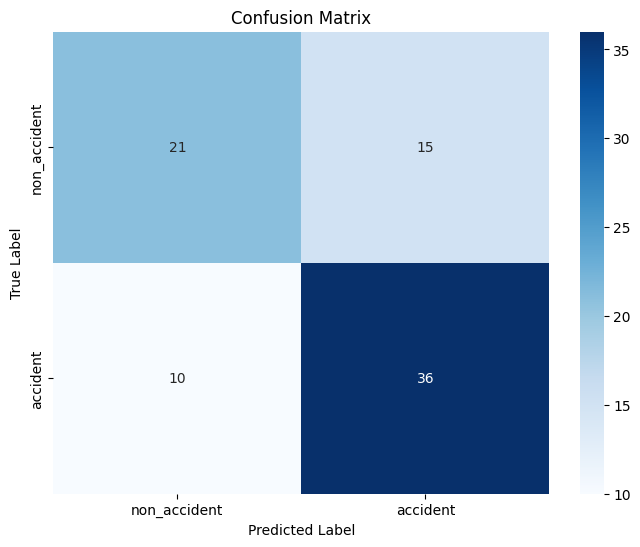

In [12]:
# Evaluate
print("\nEvaluating on test set...")
enhanced_evaluation(model, X_test, y_test, batch_size=batch_size)


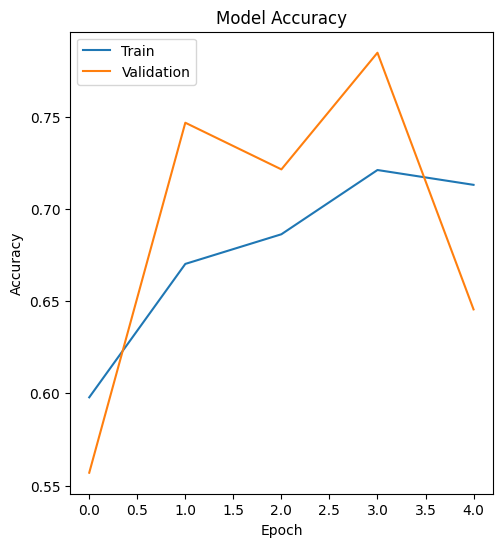

In [13]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

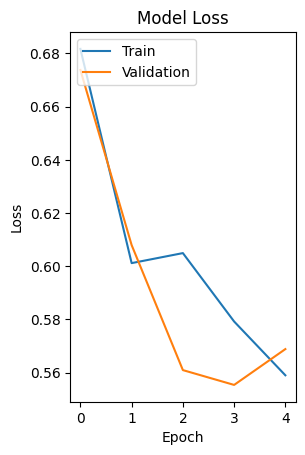

In [14]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('training_history.png')
plt.show()

3/3 [==============================] - 20s 6s/step


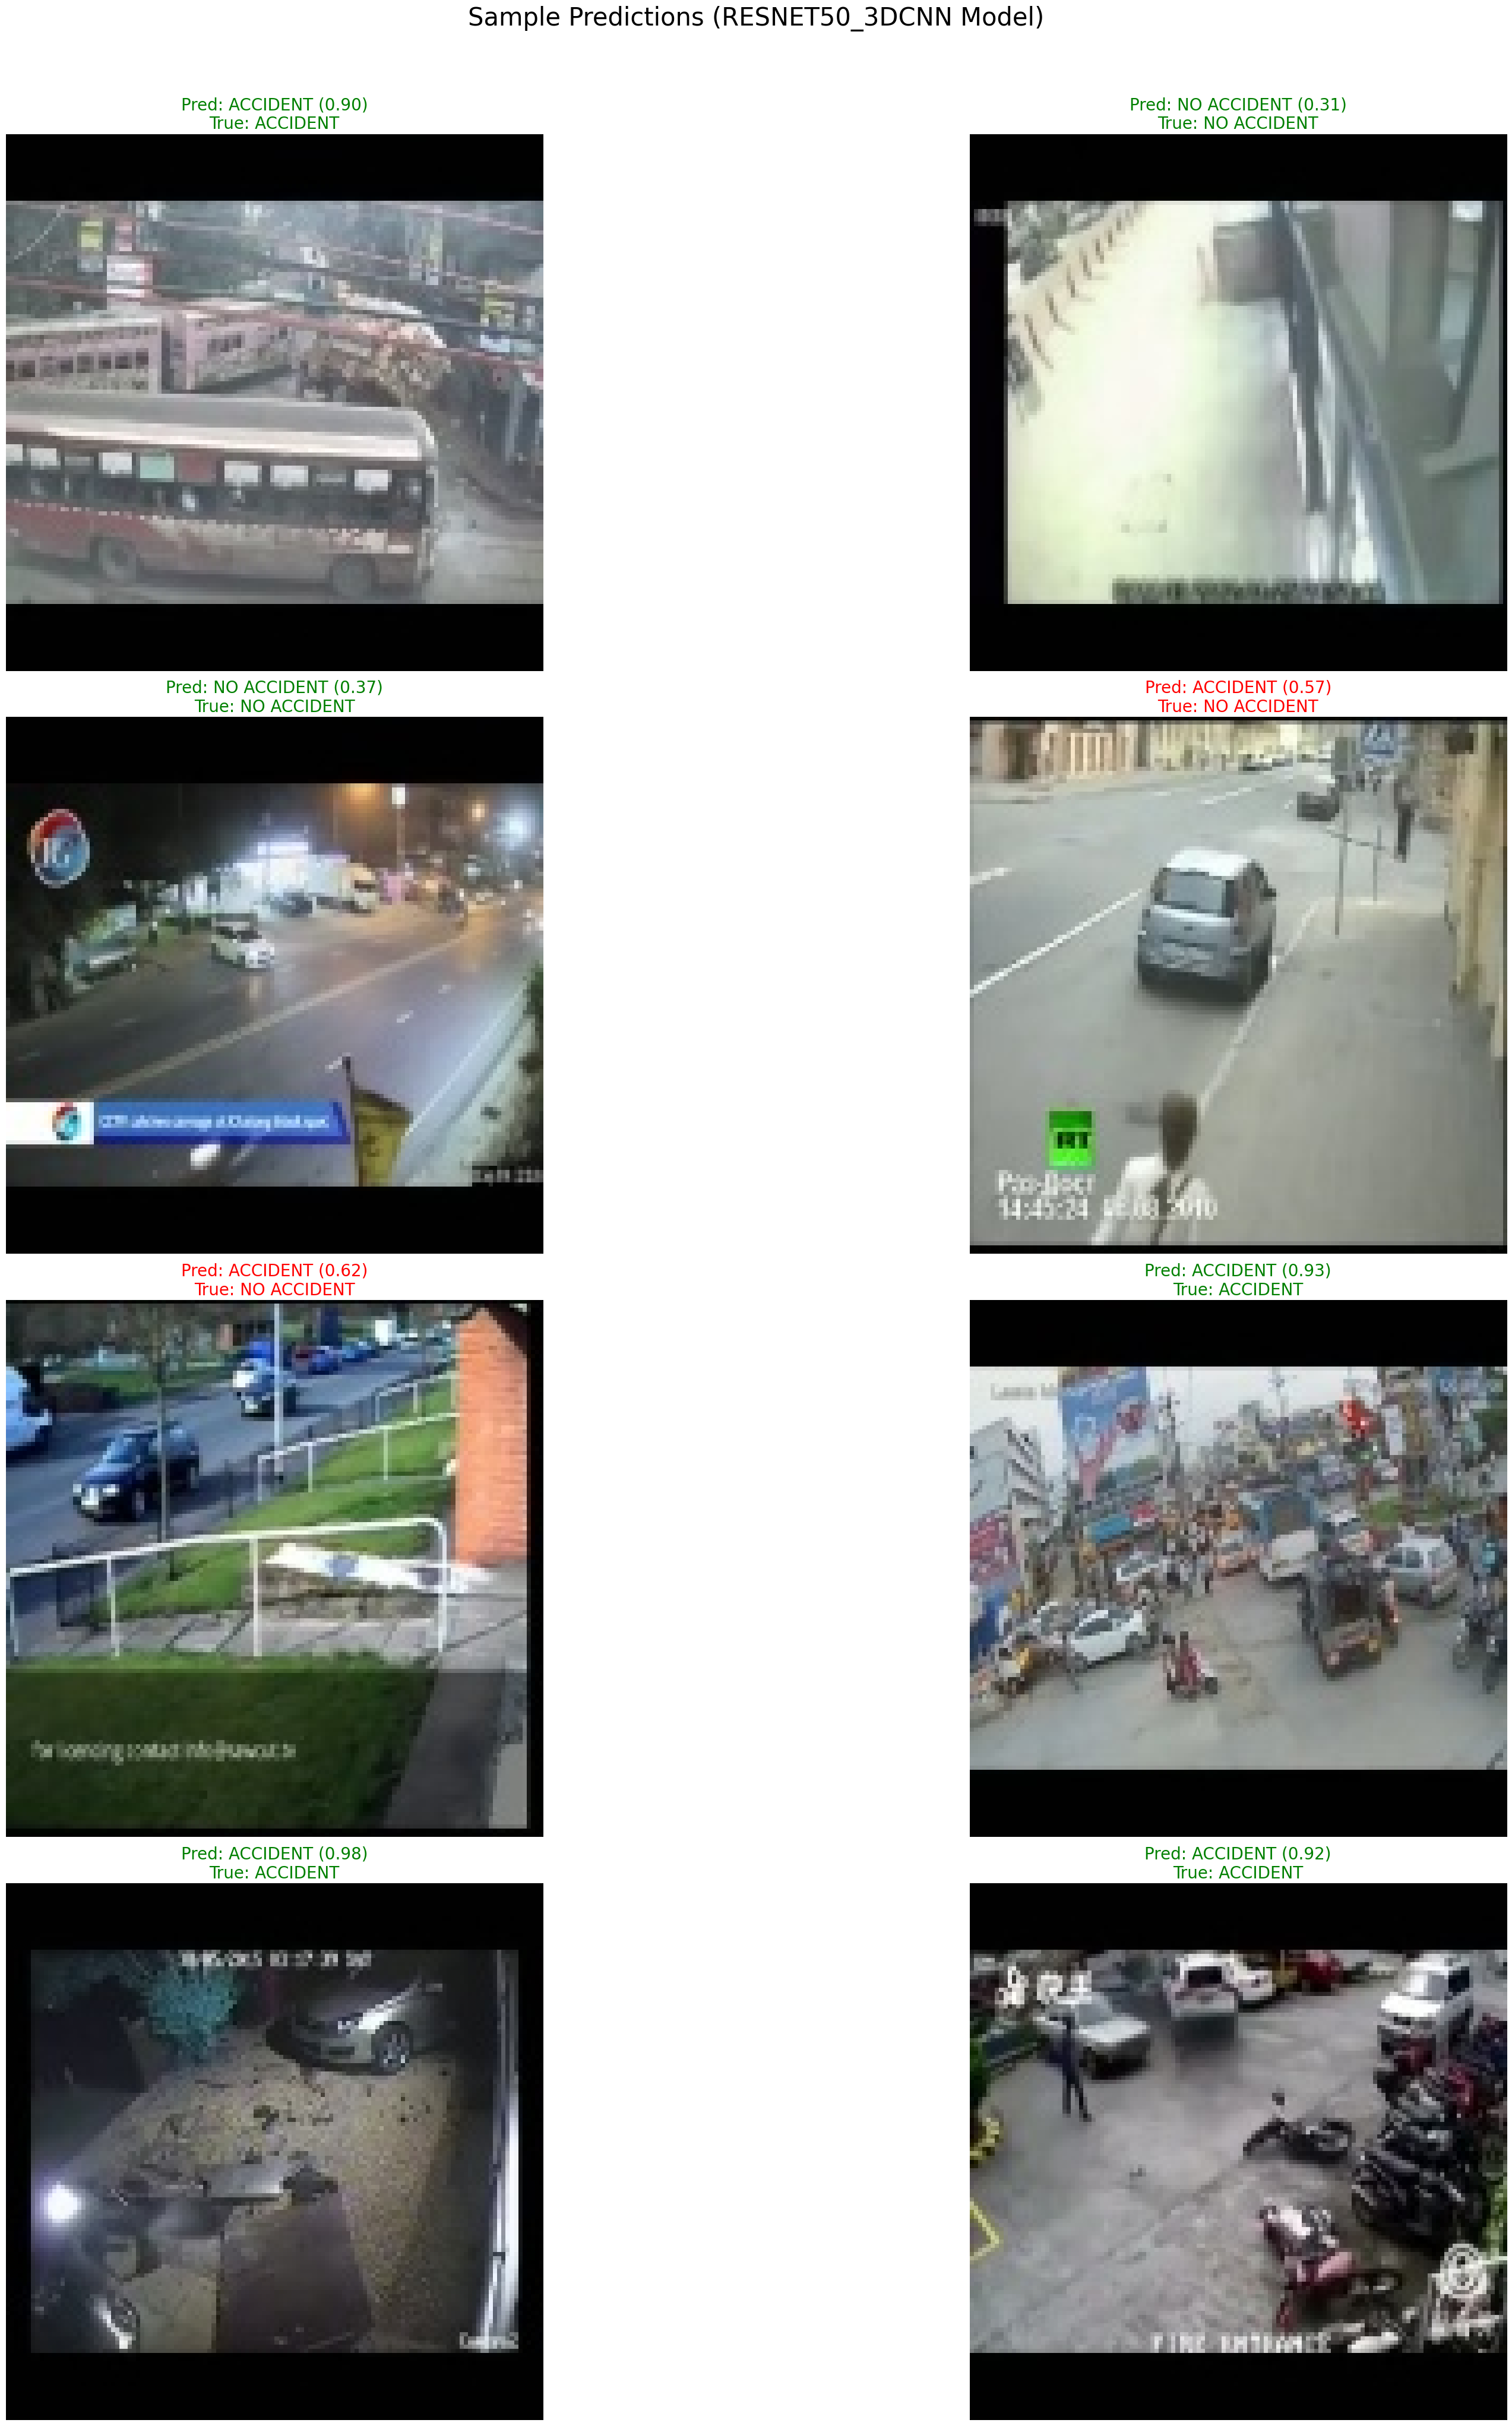


                FINAL CLASSIFICATION REPORT                 
              precision    recall  f1-score   support

NON_ACCIDENT     0.6774    0.5833    0.6269        36
    ACCIDENT     0.7059    0.7826    0.7423        46

    accuracy                         0.6951        82
   macro avg     0.6917    0.6830    0.6846        82
weighted avg     0.6934    0.6951    0.6916        82



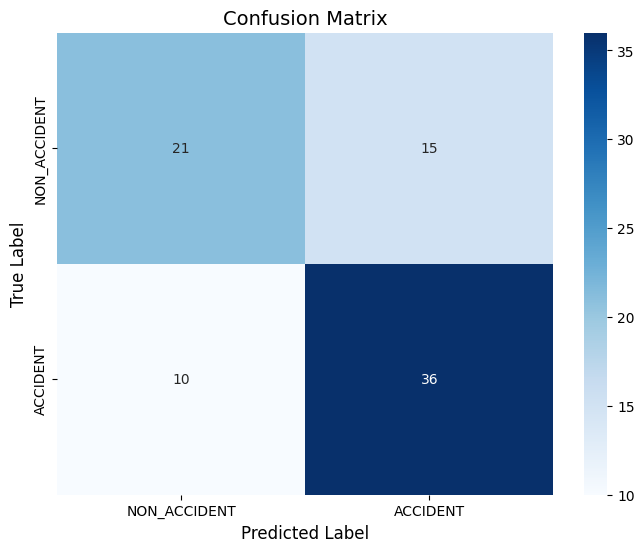

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

def visualize_predictions(model, X_test, y_test, num_samples=8, model_name='resnet_3dcnn'):
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary classes

    plt.figure(figsize=(40, 40))
    font_size = 20

    for i in range(num_samples):
        idx = np.random.randint(0, len(X_test))
        clip = X_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred_classes[idx][0]  
        pred_prob = y_pred[idx][0]

        # Extract middle frame for visualization
        middle_frame = clip[len(clip) // 2]

        ax = plt.subplot(4, 2, i + 1)
        plt.imshow(middle_frame)
        
        # Add prediction confidence to the title
        title = (f'Pred: {"ACCIDENT" if pred_label else "NO ACCIDENT"} ({pred_prob:.2f})\n'
                 f'True: {"ACCIDENT" if true_label else "NO ACCIDENT"}')
        
        # Color code based on correctness
        color = 'green' if pred_label == true_label else 'red'
        plt.title(title, fontsize=font_size, color=color)
        plt.axis('off')

    plt.suptitle(f'Sample Predictions ({model_name.upper()} Model)', y=1.02, fontsize=30)
    plt.tight_layout()
    plt.savefig(f'sample_predictions_{model_name}.png', bbox_inches='tight')
    plt.show()

    # Enhanced classification report with additional metrics
    print("\n" + "="*60)
    print("FINAL CLASSIFICATION REPORT".center(60))
    print("="*60)
    print(classification_report(y_test, y_pred_classes, 
                              target_names=['NON_ACCIDENT', 'ACCIDENT'],
                              digits=4))
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['NON_ACCIDENT', 'ACCIDENT'],
               yticklabels=['NON_ACCIDENT', 'ACCIDENT'])
    plt.title('Confusion Matrix', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.savefig(f'confusion_matrix_{model_name}.png')
    plt.show()

# Usage with our improved model
visualize_predictions(model, X_test, y_test, model_name='resnet50_3dcnn')